In [97]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# My idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent or more after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent or more after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% or more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification
LOOK_AHEAD_DAYS = 30 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))

In [98]:
# Just get the btc price points from the past year
start_date = datetime.now() - timedelta(365)
end_date = datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))

btc_original = btc_df['Open'].copy() ## save a copy of the original data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-14,10437.411133,9675.316406,10038.421875,10311.545898,2.289912e+10,10311.545898
2019-08-15,10524.349609,9855.478516,10319.419922,10374.338867,2.022821e+10,10374.338867
2019-08-16,10452.625000,10086.698242,10358.722656,10231.744141,1.377804e+10,10231.744141
2019-08-17,10487.070312,10119.094727,10233.005859,10345.810547,1.299981e+10,10345.810547
2019-08-18,10916.053711,10313.204102,10350.283203,10916.053711,1.603826e+10,10916.053711
...,...,...,...,...,...,...
2020-08-08,11806.056641,11548.784180,11737.325195,11675.739258,1.748961e+10,11675.739258
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391


In [100]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") # Introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] # Delete all duplicate indices

# Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            print(look_ahead_date)
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] >= btc_df.loc[index]['Open'] * (1 + MINIMUM_GAIN):
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
# Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

# Data is now fully processed and ready to be trained on the machine learning model
# There are 3 values for MonthTrend: UP, DOWN, NEUTRAL
# Please be careful when testing the model of leakage. There should be a LOOK_AHEAD_DAYS day gap between the train and test data sets
# otherwise, the train data set will unrealistically know something in the future
btc_open = btc_df['Open'].copy() ## save a copy of test dataset
btc_df

2019-10-27 00:00:00
2020-08-03 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00


,High,Low,Open,Close,Volume,Adj Close,MonthTrend
Date,,,,,,,
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,DOWN
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,DOWN
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,DOWN
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,DOWN
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,DOWN
...,...,...,...,...,...,...,...
2020-08-08,11806.056641,11548.784180,11737.325195,11675.739258,1.748961e+10,11675.739258,UP
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328,UP
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391,UP


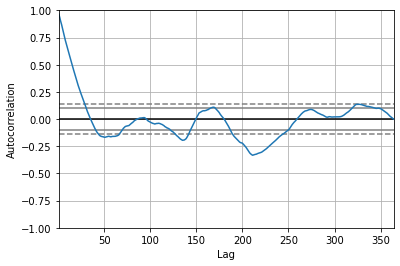

In [ ]:
## select 30 as lags
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(btc_open);

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
training_set = btc_original[:30].values ## select the first 30 days as the starting training dataset
test_set = btc_open.values ## take the rest as test dataset
history_set = list(training_set) ## define a history list to append new test data each time
predictions = list() ## save the predicted price
for t in range(len(test_set)):
  model = ARIMA(history_set, order=(5,1,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test_set[t]
  history_set.append(obs)

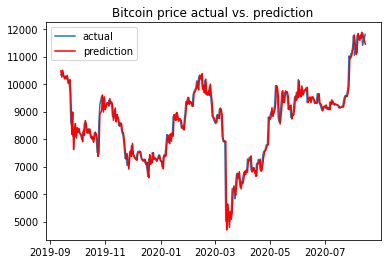

In [72]:
plt.plot(btc_open.index, test_set, label='actual');
plt.plot(btc_open.index, predictions, label='prediction', color='red');
plt.legend(loc='best');
plt.title('Bitcoin price actual vs. prediction');

In [84]:
## predict trends based on ARIMA result
trends = list()
for p in range(len(predictions)):
  if p == 0:
    if predictions[p] >= training_set[-1]:
      trends.append('UP')
    else:
      trends.append('DOWN')
  else:
    if predictions[p] >= training_set[-1]:
      trends.append('UP')
    else:
      trends.append('DOWN')

In [108]:
print(classification_report(list(btc_df['MonthTrend'].values), trends))

              precision    recall  f1-score   support

        DOWN       0.58      0.99      0.73       186
          UP       0.88      0.10      0.18       146

    accuracy                           0.60       332
   macro avg       0.73      0.55      0.46       332
weighted avg       0.72      0.60      0.49       332



In [107]:
print(confusion_matrix(list(btc_df['MonthTrend'].values), trends))

[[184   2]
 [131  15]]


In [109]:
accuracy_score(list(btc_df['MonthTrend'].values), trends)

0.5993975903614458

In [112]:
predict_trends = pd.DataFrame(index=btc_df.index, data=trends, columns=['trends'])
predict_trends

,trends
Date,
2019-09-13,UP
2019-09-14,DOWN
2019-09-15,UP
2019-09-16,DOWN
2019-09-17,DOWN
...,...
2020-08-08,UP
2020-08-09,UP
2020-08-10,UP
